# Squats

In [2]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
import math
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_drawing_styles = mp.solutions.drawing_styles

In [3]:
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converts from one colour space to the other
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
    plt.figure(figsize=(8, 6), dpi=80)
    plt.show()
    
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [3]:
squat_img = cv2.imread("assets/squat.png")

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


103.28728084686719 88.45993842975878


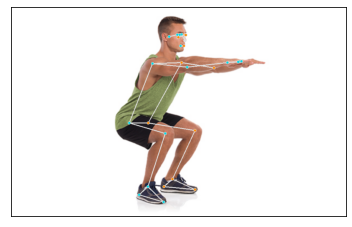

<Figure size 640x480 with 0 Axes>

In [4]:
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    results = pose.process(cv2.cvtColor(squat_img, cv2.COLOR_BGR2RGB))

    # Print nose landmark.
    image_hight, image_width, _ = squat_img.shape
   
    annotated_image = squat_img.copy()
    mp_drawing.draw_landmarks(
        annotated_image,     
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    landmarks = results.pose_landmarks.landmark
    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
    
    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
    
    
    right_angle = calculate_angle(right_hip, right_knee, right_ankle)
    left_angle = calculate_angle(left_hip, left_knee, left_ankle)
    
    print(right_angle, left_angle)
    resize_and_show(annotated_image)

Nose world landmark:
x: 0.30975696444511414
y: -0.5029168128967285
z: -0.30139124393463135
visibility: 0.99998939037323



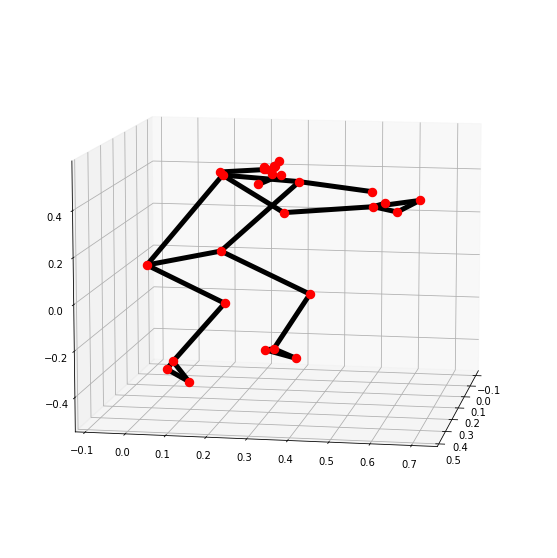

In [5]:
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
    results = pose.process(cv2.cvtColor(squat_img, cv2.COLOR_BGR2RGB))

    # Print the real-world 3D coordinates of nose in meters with the origin at
    # the center between hips.
    print('Nose world landmark:'),
    print(results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.NOSE])

    # Plot pose world landmarks.
    mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [4]:
cap = cv2.VideoCapture(0)

# Curl counter variables
counter = 0 
stage = None

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]

            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

            # Calculate angle
            right_angle = calculate_angle(right_hip, right_knee, right_ankle)
            left_angle = calculate_angle(left_hip, left_knee, left_ankle)
            
            # Visualize angle
            cv2.putText(image, str(right_angle), 
                           tuple(np.multiply(right_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            cv2.putText(image, str(right_angle), 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            
            # Curl counter logic
            
            if right_angle < 110 and left_angle < 110 and stage =='up':
                stage="down"
            if right_angle > 120 and left_angle > 120 and stage =='down':
                counter +=1
                stage = "up"
            if right_angle > 120 and left_angle > 120:
                stage = "up"
                       
        except:
            pass
        
        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (245,117,16), -1)
        
        # Rep data
        cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        # Stage data
        cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (60,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)
        
        if cv2.waitKey(10) & 0xFF == ord('r'):
            counter = 0

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
